# Gender Prediction

## Importing Libraries

In [173]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score  , precision_score, recall_score,auc, roc_auc_score, roc_curve, f1_score, confusion_matrix

## Loading Data

In [174]:
df = pd.read_csv('name_gender_all.csv', header= None)
df.head()

,0,1
0,Mary,F
1,Anna,F
2,Emma,F
3,Elizabeth,F
4,Minnie,F


## Preprocessing

In [175]:
# Adding Column names to the data
df.columns = ['Name','Gender']
df.head()

,Name,Gender
0,Mary,F
1,Anna,F
2,Emma,F
3,Elizabeth,F
4,Minnie,F


In [176]:
df['Name'] = df['Name'].str.lower()
df.head()

,Name,Gender
0,mary,F
1,anna,F
2,emma,F
3,elizabeth,F
4,minnie,F


In [177]:
df = df.drop_duplicates()

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158092 entries, 0 to 166155
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Name    158092 non-null  object
 1   Gender  158092 non-null  object
dtypes: object(2)
memory usage: 3.6+ MB


In [179]:
# Encoding Target Variable
le = LabelEncoder()
df['Gender'] =le.fit_transform(df['Gender'])
df

,Name,Gender
0,mary,0
1,anna,0
2,emma,0
3,elizabeth,0
4,minnie,0
...,...,...
166151,zujaan,1
166152,zujivan,1
166153,zukran,1
166154,zukreevan,1


- Female = 0
- Male = 1

In [180]:
# Selecting the Feature and target variable
X = df['Name']
y = df['Gender']

In [181]:
# spliting the dataset into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2,random_state= 42, stratify= y)

## Model Building

### Creating Pipeline for Logistic Regression Model

In [182]:
pipeline1 = Pipeline([
    ('vectorizer',TfidfVectorizer(analyzer='char', ngram_range=(2, 4))),
    ('classifier', LogisticRegression() )
])

In [183]:
# Fitting pipeline1 on training data
pipeline1.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(2, 4))),
                ('classifier', LogisticRegression())])

In [184]:
pipeline1.score(X_test,y_test)

0.8309244441633196

### Creating Pipeline for NultinomialNB

In [185]:
pipeline2 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='char', ngram_range=(2,4))),
    ('classifier', MultinomialNB())
])

In [186]:
# Fitting pipeline1 on training data
pipeline2.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(2, 4))),
                ('classifier', MultinomialNB())])

In [187]:
pipeline2.score(X_test,y_test)

0.7288023024131061

### Creating Pipeline for XGBoost Classifier Model

In [188]:
pipeline3 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='char', ngram_range=(2, 4))),
    ('classifier', XGBClassifier(random_state= 42))
])

In [189]:
pipeline3.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(2, 4))),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [190]:
pipeline3.score(X_test,y_test)

0.7888927543565578

### Creating Pipeline for Catboost Classifier Model

## Model Evaluation

### Creating Metrics Table for Different models

In [191]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])

def metrics_table(name, model, xtest, ytest, metrics_df):
    y_pred = model.predict(xtest)
    
    try:
        y_pred_prob = model.predict_proba(xtest)[:, 1]
        auc = roc_auc_score(ytest, y_pred_prob)
    except:
        auc = None

    new_row = pd.DataFrame({
        'Model': [name],
        'Accuracy': [accuracy_score(ytest, y_pred)],
        'Precision': [precision_score(ytest, y_pred)],
        'Recall': [recall_score(ytest, y_pred)],
        'F1-Score': [f1_score(ytest, y_pred)],
        'AUC': [auc]
    })

    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)
    return metrics_df

In [192]:
models = {'Logistic Regression' :pipeline1,
          'Multinomial NB': pipeline2,
          'Xgboost': pipeline3
}

In [193]:
for name, model in models.items():
        metrics_df = metrics_table(name, model, X_test, y_test, metrics_df)

metrics_df

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Logistic Regression,0.830924,0.814956,0.786505,0.800478,0.901829
1,Multinomial NB,0.728802,0.707377,0.632930,0.668086,0.800930
2,Xgboost,0.788893,0.762721,0.740961,0.751683,0.872051


### Confusion Matrics for Different Models

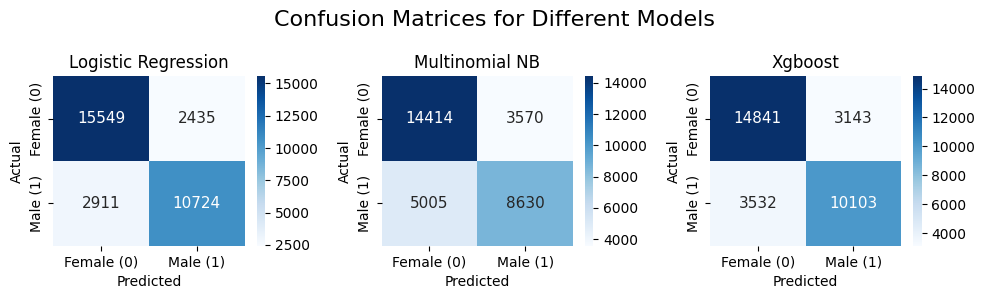

In [194]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
fig.suptitle('Confusion Matrices for Different Models', fontsize=16)
i = 0
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={'size': 11}, xticklabels=['Female (0)','Male (1)'], yticklabels=['Female (0)','Male (1)'], cmap='Blues', ax= axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    i += 1
plt.tight_layout()
plt.show()

### AUC - ROC Curve (For Best Model i.e `XGBoost`)

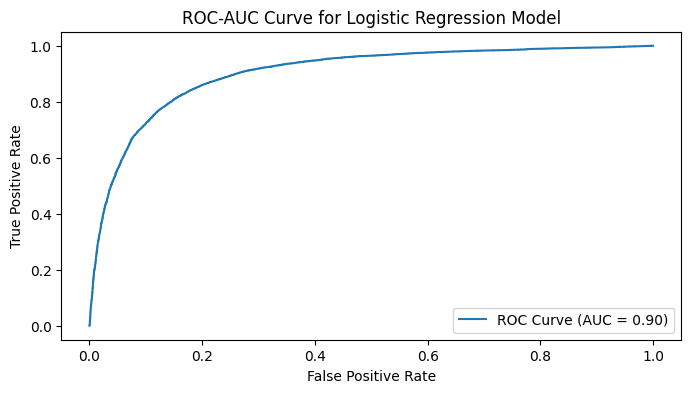

In [195]:
# ROC-AUC Curve
plt.figure(figsize=(8, 4))
y_proba = pipeline1.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label= f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")

plt.title("ROC-AUC Curve for Logistic Regression Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model Deployment

In [196]:
joblib.dump(pipeline1, "gender_predictor_pipeline.pkl")

['gender_predictor_pipeline.pkl']